# DataSHIELD Python Demo

1. Establish connections with DataSHIELD nodes

In [22]:
from datashield import DSSession, DSLoginBuilder, DSError
import pandas as pd

url = "https://opal-demo.obiba.org"
builder = DSLoginBuilder().add("server1", url, "dsuser", "P@ssw0rd").add("server2", url, "dsuser", "P@ssw0rd")
logins = builder.build()

session = DSSession(logins)
session.open()

2. Utility functions

In [2]:
session.profiles()

{'server1': {'available': ['default',
   'exposome',
   'geo',
   'lemon-donkey',
   'margin-idiom',
   'mediation',
   'mtl',
   'omics',
   'omop',
   'survival'],
  'current': 'default'},
 'server2': {'available': ['default',
   'exposome',
   'geo',
   'lemon-donkey',
   'margin-idiom',
   'mediation',
   'mtl',
   'omics',
   'omop',
   'survival'],
  'current': 'default'}}

In [3]:
pkgs = session.packages()
pd.DataFrame.from_records(pkgs["server1"])

,pkg,version
0,dsTidyverse,1.1.0
1,dsBase,6.3.4
2,resourcer,1.5.0


In [4]:
methods = session.methods(type="aggregate")
pd.DataFrame.from_records(methods["server1"])

,name,class,value,pkg,version
0,NROW,func,base::NROW,dsBase,6.3.4
1,asFactorDS1,func,dsBase::asFactorDS1,dsBase,6.3.4
2,asListDS,func,dsBase::asListDS,dsBase,6.3.4
3,aucDS,func,dsBase::aucDS,dsBase,6.3.4
4,boxPlotGGDS,func,dsBase::boxPlotGGDS,dsBase,6.3.4
...,...,...,...,...,...
67,tableDS,func,dsBase::tableDS,dsBase,6.3.4
68,tableDS2,func,dsBase::tableDS2,dsBase,6.3.4
69,tapplyDS,func,dsBase::tapplyDS,dsBase,6.3.4
70,testObjExistsDS,func,dsBase::testObjExistsDS,dsBase,6.3.4


In [5]:
session.tables()

{'server1': ['CNSIM.CNSIM1',
  'CNSIM.CNSIM2',
  'CNSIM.CNSIM3',
  'DASIM.DASIM1',
  'DASIM.DASIM2',
  'DASIM.DASIM3',
  'DISCORDANT.DISCORDANT_STUDY1',
  'DISCORDANT.DISCORDANT_STUDY2',
  'DISCORDANT.DISCORDANT_STUDY3',
  'GREENSPACE.Cohort1_exposome',
  'GREENSPACE.Cohort2_exposome',
  'GREENSPACE.Cohort3_exposome',
  'GWAS.ega_phenotypes',
  'GWAS.ega_phenotypes_1',
  'GWAS.ega_phenotypes_2',
  'GWAS.ega_phenotypes_3',
  'MEDIATION.UPBdata1',
  'MEDIATION.UPBdata2',
  'MEDIATION.UPBdata3',
  'SURVIVAL.EXPAND_WITH_MISSING1',
  'SURVIVAL.EXPAND_WITH_MISSING2',
  'SURVIVAL.EXPAND_WITH_MISSING3',
  'TESTING.TESTING1',
  'TESTING.TESTING2',
  'TESTING.TESTING3',
  'TITANIC_NEWCOMERS_WORKSHOP.titanic_server_1',
  'TITANIC_NEWCOMERS_WORKSHOP.titanic_server_2',
  'depression.growth_1',
  'depression.growth_2'],
 'server2': ['CNSIM.CNSIM1',
  'CNSIM.CNSIM2',
  'CNSIM.CNSIM3',
  'DASIM.DASIM1',
  'DASIM.DASIM2',
  'DASIM.DASIM3',
  'DISCORDANT.DISCORDANT_STUDY1',
  'DISCORDANT.DISCORDANT_STUD

In [355]:
# session.resources()

3. Make analysis

In [26]:
session.assign_resource("client", resources={"server1": "RSRC.CNSIM1", "server2": "RSRC.CNSIM1"})
session.ls()

{'server1': ['client', 'df'], 'server2': ['client']}

In [27]:
session.aggregate('classDS("client")')

{'server1': ['SQLResourceClient', 'ResourceClient', 'R6'],
 'server2': ['SQLResourceClient', 'ResourceClient', 'R6']}

In [28]:
session.assign_expr("df", "as.resource.data.frame(client, strict = TRUE)")
session.ls()

{'server1': ['client', 'df'], 'server2': ['client', 'df']}

In [29]:
session.aggregate('classDS("df")')

{'server1': 'data.frame', 'server2': 'data.frame'}

In [30]:
session.aggregate('colnamesDS("df")')

{'server1': ['id',
  'LAB_TSC',
  'LAB_TRIG',
  'LAB_HDL',
  'LAB_GLUC_ADJUSTED',
  'PM_BMI_CONTINUOUS',
  'DIS_CVA',
  'MEDI_LPD',
  'DIS_DIAB',
  'DIS_AMI',
  'GENDER',
  'PM_BMI_CATEGORICAL'],
 'server2': ['id',
  'LAB_TSC',
  'LAB_TRIG',
  'LAB_HDL',
  'LAB_GLUC_ADJUSTED',
  'PM_BMI_CONTINUOUS',
  'DIS_CVA',
  'MEDI_LPD',
  'DIS_DIAB',
  'DIS_AMI',
  'GENDER',
  'PM_BMI_CATEGORICAL']}

In [31]:
session.aggregate("meanDS(df$LAB_GLUC_ADJUSTED)")

{'server1': {'EstimatedMean': 6.12409001097695,
  'Nmissing': 341,
  'Nvalid': 1822,
  'Ntotal': 2163,
  'ValidityMessage': 'VALID ANALYSIS'},
 'server2': {'EstimatedMean': 6.12409001097695,
  'Nmissing': 341,
  'Nvalid': 1822,
  'Ntotal': 2163,
  'ValidityMessage': 'VALID ANALYSIS'}}

In [32]:
session.assign_table("df2", tables={"server1": "CNSIM.CNSIM1", "server2": "CNSIM.CNSIM2"})
session.ls()

{'server1': ['client', 'df', 'df2'], 'server2': ['client', 'df', 'df2']}

In [33]:
numints = 20
densityGrid = session.aggregate(
    f"densityGridDS(df2$LAB_TSC, df2$LAB_HDL, limits=FALSE, x.min=NULL, x.max=NULL, y.min=NULL, y.max=NULL, numints = {numints})"
)
densityGrid["server1"]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2.59225,
  0.068282325],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2.95275,
  0.208472975],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3.31325,
  0.348663625],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  4,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  3.67375,
  0.488854275],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  8,
  3,
  8,
  7,
  6,
  11,
  0,
  6,
  0,
  0,
  0,
  0,
  4.03425,
  0.629044925],
 [0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  4,
  13,
  16,
  6,
  12,
  12,
  9,
  6,
  4,
  0,
  0,
  0,
  4.39475,
  0.769235575],
 [0,
  0,
  0,
  0,
  0,
  0,
  3,
  7,
  11,
  14,
  16,
  28,
  25,
  16,
  9,
  9,
  10,
  0,
  0,
  0,
  4.75525,
  0.909426225],
 [0,
  0,
  0,
  0,
  0,
  0,
  4,
  7,
  19,
  21,
  28,
  31,
  26,
  27,
  13,
  10,
  0,
  3,
 

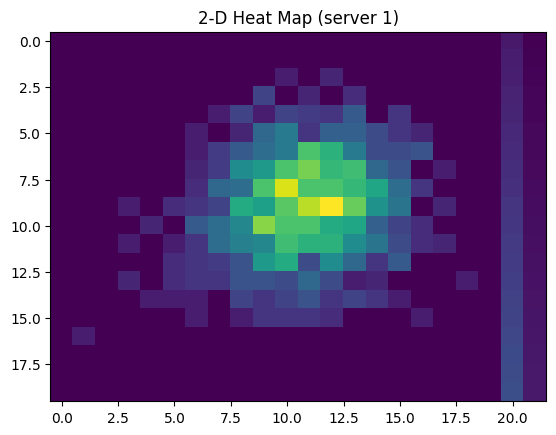

In [34]:
import matplotlib.pyplot as plt

plt.imshow(densityGrid["server1"], aspect="auto")
plt.title("2-D Heat Map (server 1)")
plt.show()

In [35]:
data = session.aggregate(
    "histogramDS2(df2$LAB_GLUC_ADJUSTED, num.breaks=20, min=0, max=20, method.indicator=1, k=3, noise=0.25)"
)
data["server1"]

{'type': 'list',
 'attributes': {'names': {'type': 'character',
   'attributes': {},
   'value': ['histobject', 'invalidcells']}},
 'value': [{'type': 'list',
   'attributes': {'names': {'type': 'character',
     'attributes': {},
     'value': ['breaks', 'counts', 'density', 'mids', 'xname', 'equidist']},
    'class': {'type': 'character', 'attributes': {}, 'value': ['histogram']}},
   'value': [{'type': 'double',
     'attributes': {},
     'value': [0,
      1,
      2,
      3,
      4,
      5,
      6,
      7,
      8,
      9,
      10,
      11,
      12,
      13,
      14,
      15,
      16,
      17,
      18,
      19,
      20]},
    {'type': 'double',
     'attributes': {},
     'value': [0,
      0,
      9,
      60,
      277,
      521,
      558,
      281,
      80,
      9,
      4,
      11,
      5,
      5,
      0,
      0,
      0,
      0,
      0,
      0]},
    {'type': 'double',
     'attributes': {},
     'value': [0,
      0,
      0.00493963,
      0.

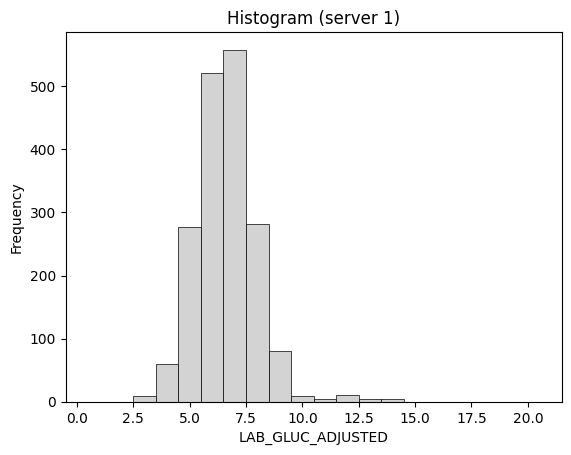

In [36]:
breaks = data["server1"]["value"][0]["value"][0]["value"]
counts = data["server1"]["value"][0]["value"][1]["value"]

plt.bar(breaks[1:], counts, width=1, edgecolor="black", linewidth=0.5, color="lightgrey")
plt.xlabel("LAB_GLUC_ADJUSTED")
plt.ylabel("Frequency")
plt.title("Histogram (server 1)")
plt.show()

In [ ]:
try:
    session.aggregate('heatmapPlotDS(df2$LAB_TSC, df2$LAB_HDL, 3, 0.25, "xxx")')
except DSError:
    print(session.get_errors()["server1"])
    print(session.get_errors()["server1"].is_client_error())
    print(session.get_errors()["server1"].is_server_error())

Command 2e62e66a-87e7-4eb9-917f-91197716327b-12 failed on server1: Error while evaluating 'dsBase::heatmapPlotDS("df2$LAB_TSC", "df2$LAB_HDL", 3, 0.25, "xxx")' -> Error in dsBase::heatmapPlotDS("df2$LAB_TSC", "df2$LAB_HDL", 3, 0.25,  : 
  object 'x.new' not found

True
False


4. Cleanup

In [21]:
session.close()